# 2. Modeling 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pprint
from tqdm.notebook import tqdm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import time

In [6]:
df = pd.read_pickle('dataset/train_fillna_max.pkl').rename({'order_quantity_bin':'TARGET'},axis=1)
# df = df[df.period>='2017-07'].reset_index()
train = df

## 2.1. Separating Training & Test Data

In [7]:
feature_names = [e for e in df.columns if e not in ('period','part_id','TARGET','order_quantity')]

In [8]:
train_x = df[feature_names]
train_y = df['TARGET']

## 2.2. Feature Selection

### 2.2.1. Selecting Best Features

In [5]:
def plot_coefficients(coef, feature_names, top_features=20):
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    # print('2*top_features')
    # print(np.arange(2 * top_features))
    # print('coef[top_coefficients]')
    # print(coef[top_coefficients])
    # print('colors')
    # print(colors)
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    plt.title('Feature Importances according to SVM Coefficients')
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    return feature_names[top_positive_coefficients],coef[top_positive_coefficients],feature_names[top_negative_coefficients],coef[top_negative_coefficients]

train_x_norm = np.empty(train_x.shape)
count = 0
for col in feature_names:
    x = np.array(train_x[col])
    x_norm = x / np.linalg.norm(x)
    train_x_norm[:,count] = x_norm
    count+=1

In [7]:
svm = LinearSVR(
          tol=0.0001,
          loss='squared_epsilon_insensitive',
          fit_intercept=True,
          intercept_scaling=1.0,
          dual=False,
          max_iter=1000)
svm.fit(train_x_norm, train_y)

LinearSVR(dual=False, loss='squared_epsilon_insensitive')

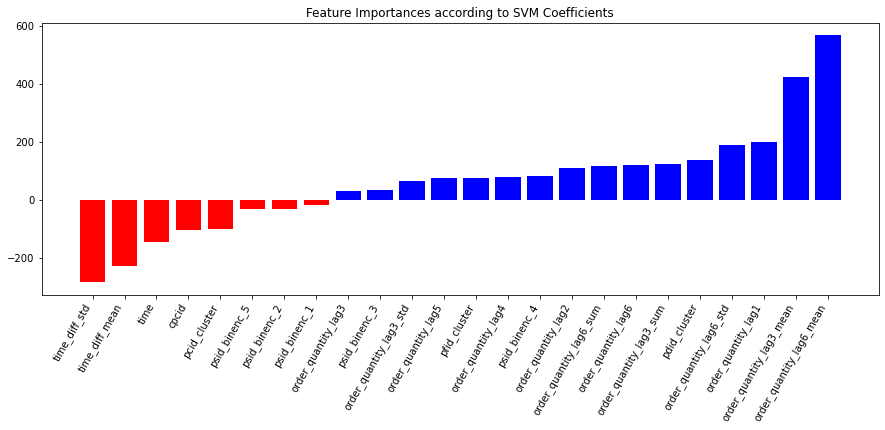

In [8]:
coef = svm.coef_
top_positive_features = []
top_negative_features = []

pnames, pcoef, nnames, ncoef = plot_coefficients(coef,feature_names,12)
top_positive_features.append((1,pnames,pcoef))
top_negative_features.append((1,nnames,ncoef))

In [9]:
importances_1 = pd.DataFrame([top_positive_features[0][1],top_positive_features[0][2]]).T
importances_1.columns = ['feature','coef_1_positive']
importances_positive = importances_1
importances_1 = pd.DataFrame([top_negative_features[0][1],top_negative_features[0][2]]).T
importances_1.columns = ['feature','coef_1_negative']
importances_negative = importances_1
importances = importances_positive.merge(importances_negative,how='outer',on='feature')
importances.set_index('feature',inplace=True)
importances['sum'] = importances.abs().sum(axis=1)
importances.sort_values('sum',ascending=False,inplace=True)
importances['rank'] = range(1,importances.shape[0]+1)
corr_matrix = train_x[importances.index.tolist()].corr().abs()

### 2.2.2. Dropping Highly Correlated Features

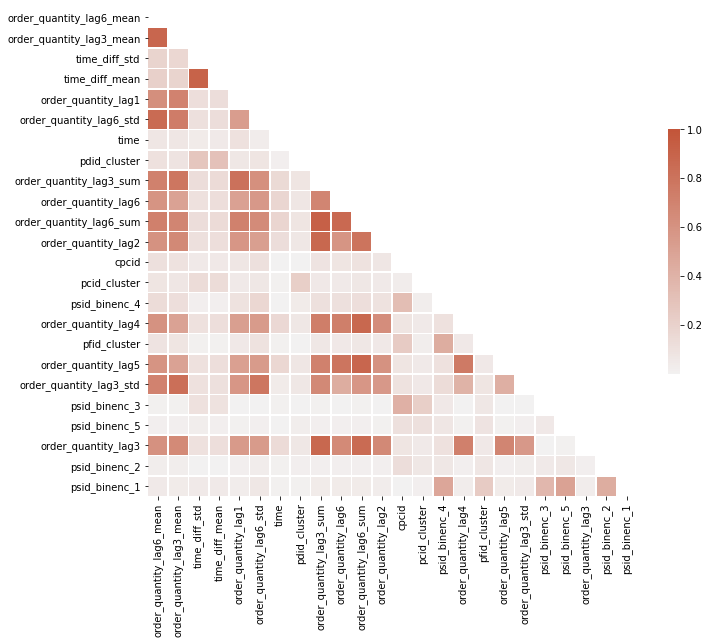

In [10]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, center=0.0,
            square=True, linewidths=.6, cbar_kws={"shrink": .5});

In [11]:
importances

,coef_1_positive,coef_1_negative,sum,rank
feature,,,,
order_quantity_lag6_mean,568.041,NaN,568.040763,1
order_quantity_lag3_mean,424.614,NaN,424.614037,2
time_diff_std,NaN,-283.789,283.788874,3
time_diff_mean,NaN,-226.788,226.788269,4
order_quantity_lag1,201.599,NaN,201.599480,5
order_quantity_lag6_std,190.112,NaN,190.112138,6
time,NaN,-143.576,143.575803,7
pdid_cluster,138.709,NaN,138.709195,8
order_quantity_lag3_sum,124.671,NaN,124.670558,9


In [12]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop=[]
for col in upper.columns:
    tmp = upper.loc[col]>0.90
    compare_with = tmp[tmp==True].index.tolist()
    current_rank = importances.loc[col]['rank']
    if(len(compare_with)==0):
        continue
    else:
        print('current col: '+col+' current rank: '+str(current_rank))
        win=0
        print('starting to compare with: '+str(compare_with))
        for col2 in compare_with:
            print('col2: '+ col2+' col2.rank: '+str(importances.loc[col2]['rank']))
            if current_rank < importances.loc[col2]['rank']:
                to_drop+=[col2]
print('to_drop: ')
print(set(to_drop))

current col: time_diff_std current rank: 3
starting to compare with: ['time_diff_mean']
col2: time_diff_mean col2.rank: 4
current col: order_quantity_lag3_sum current rank: 9
starting to compare with: ['order_quantity_lag6_sum']
col2: order_quantity_lag6_sum col2.rank: 11
to_drop: 
{'time_diff_mean', 'order_quantity_lag6_sum'}


In [13]:
final_features = [e for e in feature_names if e not in set(to_drop)]

In [14]:
final_features

['order_quantity_lag1',
 'order_quantity_lag2',
 'order_quantity_lag3',
 'order_quantity_lag4',
 'order_quantity_lag5',
 'order_quantity_lag6',
 'order_quantity_lag3_mean',
 'order_quantity_lag3_std',
 'order_quantity_lag3_sum',
 'order_quantity_lag6_mean',
 'order_quantity_lag6_std',
 'pdid_cluster',
 'pfid_cluster',
 'pcid_cluster',
 'psid_binenc_1',
 'psid_binenc_2',
 'psid_binenc_3',
 'psid_binenc_4',
 'psid_binenc_5',
 'cpcid',
 'time',
 'time_diff_std']

## 2.3. Model Selection 

In [15]:
ix = {}
lag = 3
folds = 3
for fold in range(1,(1+folds)):
    train_till = (-1*lag*fold)
    valid_till = None if (-1*lag*(fold-1)) == 0 else (-1*lag*(fold-1))
    ix[fold] = {'train':df[df.period.isin(df.period.unique()[:train_till])].index,
                'valid':df[df.period.isin(df.period.unique()[train_till:valid_till])].index}

In [16]:
def run_kfold_model(df,model,model_name,final_features,fold_indexes,folds=[1,2,3]):
    results = {}
    for fold in folds:
        print('='*5+' '+model_name+' - fold '+str(fold)+' '+'='*5)
        train = df.loc[fold_indexes[fold]['train']]
        valid = df.loc[fold_indexes[fold]['valid']]

        train_x = train[final_features]
        valid_x = valid[final_features]

        train_y = train['TARGET']
        valid_y = valid['TARGET']
        print('fitting model...')
        start_time = time.time()
        model.fit(train_x, train_y)
        ex_time = (time.time() - start_time)
        print('model fit!')
        train_y_pred = model.predict(train_x)
        valid_y_pred = model.predict(valid_x)
        results[fold] = {}
        results[fold]['metrics']={
            'mse_train':mean_squared_error(train_y,train_y_pred),
            'mae_train':mean_absolute_error(train_y,train_y_pred),
            'mse_valid':mean_squared_error(valid_y,valid_y_pred),
            'mae_valid':mean_absolute_error(valid_y,valid_y_pred)
        }
        results[fold]['preds'] = {
            'train_y_pred': train_y_pred,
            'valid_y_pred': valid_y_pred
        }
        results[fold]['execution_time'] = ex_time
        pprint.pprint(results[fold])
    return results, model

### 2.3.1. K-Nearest Neighbor Regressor (KNN)

In [17]:
neighbors_list = [2,3,4,5,6,7,8,9,10,20]
neighbors_list = [5]

In [18]:
cumulative_model_results_knn = {}
for neighbor in neighbors_list:
    knn = KNeighborsRegressor(
        n_neighbors=neighbor,
        weights='uniform',
        algorithm='auto',
        leaf_size=30,
        p=2,
        metric='minkowski')
    results, knn = run_kfold_model(df,knn,'K-Nearest Neighbor',final_features,ix,folds=[1,2,3])
    cumulative_model_results_knn[neighbor] = {'results':results,'model':knn}

===== K-Nearest Neighbor - fold 1 =====
fitting model...
model fit!
{'execution_time': 5.053981065750122,
 'metrics': {'mae_train': 3.484939398522942,
             'mae_valid': 3.9258,
             'mse_train': 37.584517062456015,
             'mse_valid': 49.839288},
 'preds': {'train_y_pred': array([ 4.8, 10.2, 12.6, ...,  6.6,  3. ,  9.6]),
           'valid_y_pred': array([3.6, 3.6, 1.2, ..., 6. , 0.6, 6. ])}}
===== K-Nearest Neighbor - fold 2 =====
fitting model...
model fit!
{'execution_time': 4.336127996444702,
 'metrics': {'mae_train': 3.5203437935487636,
             'mae_valid': 3.8183199999999995,
             'mse_train': 38.047906959776455,
             'mse_valid': 48.118463999999996},
 'preds': {'train_y_pred': array([ 4.8, 10.2, 12.6, ...,  1.8,  1.8,  6. ]),
           'valid_y_pred': array([2.4, 1.8, 3. , ..., 5.4, 2.4, 4.8])}}
===== K-Nearest Neighbor - fold 3 =====
fitting model...
model fit!
{'execution_time': 4.088913202285767,
 'metrics': {'mae_train': 3.56904120

### 2.3.2. Random Forest (RF)

In [19]:
estimators_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
estimators_list = [100]

In [20]:
cumulative_model_results_rf = {}
for estimator in estimators_list:
    rf = RandomForestRegressor(
        n_estimators=estimator,
        criterion='mse',
        max_depth=7,
        min_samples_split=100,
        min_samples_leaf=40,
        min_weight_fraction_leaf=0.0,
        max_features='auto',
        max_leaf_nodes=45,
        min_impurity_decrease=0.0,
        bootstrap=True,);
    results, rf = run_kfold_model(df,rf,'Random Forest',final_features,ix,folds=[1,2,3])
    cumulative_model_results_rf[estimator] = {'results':results,'model':rf}

===== Random Forest - fold 1 =====
fitting model...
model fit!
{'execution_time': 58.62010598182678,
 'metrics': {'mae_train': 3.9569263173493,
             'mae_valid': 3.668855540019597,
             'mse_train': 45.695900441146634,
             'mse_valid': 43.012272790634434},
 'preds': {'train_y_pred': array([ 6.99115922,  7.1516825 , 12.42188895, ...,  5.58538088,
        1.70165151,  8.07574258]),
           'valid_y_pred': array([ 5.3184712 ,  3.46182686, 10.82674797, ...,  5.32749713,
        1.70165151, 11.43446086])}}
===== Random Forest - fold 2 =====
fitting model...
model fit!
{'execution_time': 53.7037570476532,
 'metrics': {'mae_train': 3.9985376711185356,
             'mae_valid': 3.5785157128728633,
             'mse_train': 46.32679778449603,
             'mse_valid': 40.082725608231314},
 'preds': {'train_y_pred': array([ 7.13607465,  7.28321002, 12.90062592, ...,  6.46373412,
        1.63699908,  7.97265964]),
           'valid_y_pred': array([6.53507941, 5.1683177

### 2.3.3. Gradient Boosting (GB)

In [21]:
estimators_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
estimators_list = [100]

In [22]:
cumulative_model_results_gb = {}
for estimator in estimators_list:
    gb = GradientBoostingRegressor(
        loss='ls',
        learning_rate=0.01,
        n_estimators=estimator,
        criterion='friedman_mse',
        min_samples_split=100,
        min_samples_leaf=40,
        min_weight_fraction_leaf=0.0,
        max_depth=7,
        min_impurity_decrease=0.0,
        alpha=0.9,
        verbose=0,
        max_leaf_nodes=45,
        n_iter_no_change=50,
        tol=0.0001,);
    results, gb = run_kfold_model(df,gb,'Gradient Boosting',final_features,ix,folds=[1,2,3])
    cumulative_model_results_gb[estimator] = {'results':results,'model':gb}

===== Gradient Boosting - fold 1 =====
fitting model...
model fit!
{'execution_time': 103.10436606407166,
 'metrics': {'mae_train': 4.147303192851255,
             'mae_valid': 3.7970662229186014,
             'mse_train': 50.332081322392966,
             'mse_valid': 44.89426438797418},
 'preds': {'train_y_pred': array([ 6.57194837,  6.85005353, 13.63323907, ...,  5.64282033,
        2.87641557,  6.91269696]),
           'valid_y_pred': array([5.14686653, 4.11561055, 8.64766901, ..., 5.34021858, 2.87641557,
       8.69717214])}}
===== Gradient Boosting - fold 2 =====
fitting model...
model fit!
{'execution_time': 90.12952589988708,
 'metrics': {'mae_train': 4.203369303076123,
             'mae_valid': 3.7519926340360086,
             'mse_train': 51.317779072899086,
             'mse_valid': 42.86798534340403},
 'preds': {'train_y_pred': array([ 6.60198006,  6.59943414, 10.31549131, ...,  5.94095364,
        2.87069493,  6.83449112]),
           'valid_y_pred': array([5.84375502, 5.24

# 3. Evaluation 

In [23]:
def get_metrics_from_results(dct):
    res = {}
    for key in dct.keys():
        tmp = dct[key]
        dfs = []
        for fold in tmp['results'].keys():
            dfs.append(pd.DataFrame.from_dict(tmp['results'][fold]['metrics'],orient='index',columns=['fold_'+str(fold)]))
        res[key] = pd.concat(dfs,axis=1)
    return res

In [24]:
knn_results = get_metrics_from_results(cumulative_model_results_knn)[5]
knn_results['avg'] = knn_results.mean(axis=1)
knn_results

,fold_1,fold_2,fold_3,avg
mse_train,37.584517,38.047907,38.694519,38.108981
mae_train,3.484939,3.520344,3.569041,3.524775
mse_valid,49.839288,48.118464,47.510304,48.489352
mae_valid,3.925800,3.818320,3.857040,3.867053


In [25]:
rf_results = get_metrics_from_results(cumulative_model_results_rf)[100]
rf_results['avg'] = rf_results.mean(axis=1)
rf_results

,fold_1,fold_2,fold_3,avg
mse_train,45.695900,46.326798,47.111975,46.378224
mae_train,3.956926,3.998538,4.044540,4.000001
mse_valid,43.012273,40.082726,41.004362,41.366454
mae_valid,3.668856,3.578516,3.624563,3.623978


In [26]:
gb_results = get_metrics_from_results(cumulative_model_results_gb)[100]
gb_results['avg'] = gb_results.mean(axis=1)
gb_results

,fold_1,fold_2,fold_3,avg
mse_train,50.332081,51.317779,52.331197,51.327019
mae_train,4.147303,4.203369,4.279848,4.210173
mse_valid,44.894264,42.867985,43.373385,43.711878
mae_valid,3.797066,3.751993,3.862884,3.803981


## 3.2. Error Rate in Total Monthly Orders

In [27]:
df['period_str'] = df.period.astype(str)
monthly_orders = pd.DataFrame(df.groupby('period_str').order_quantity.sum(),columns=['order_quantity']).reset_index()

In [28]:
def get_monthly_orders_from_results(dct):
    res = {}
    for key in dct.keys():
        tmp = dct[key]
        dfs = []
        for fold in tmp['results'].keys():
            r = np.hstack((tmp['results'][fold]['preds']['train_y_pred'],tmp['results'][fold]['preds']['valid_y_pred']))
            dfs.append(r)
        res[key] = pd.DataFrame(dfs).T
    return res

In [29]:
monthly_orders_knn = get_monthly_orders_from_results(cumulative_model_results_knn)[5]
monthly_orders_knn['avg'] = monthly_orders_knn.mean(axis=1)
monthly_orders_knn = pd.concat([df.period_str,monthly_orders_knn],axis=1)
monthly_orders_knn = pd.DataFrame(monthly_orders_knn.groupby('period_str')['avg'].sum()).reset_index().rename({'avg':'order_quantity_knn'},axis=1)

In [30]:
monthly_orders_rf = get_monthly_orders_from_results(cumulative_model_results_rf)[100]
monthly_orders_rf['avg'] = monthly_orders_rf.mean(axis=1)
monthly_orders_rf = pd.concat([df.period_str,monthly_orders_rf],axis=1)
monthly_orders_rf = pd.DataFrame(monthly_orders_rf.groupby('period_str')['avg'].sum()).reset_index().rename({'avg':'order_quantity_rf'},axis=1)

In [31]:
monthly_orders_gb = get_monthly_orders_from_results(cumulative_model_results_gb)[100]
monthly_orders_gb['avg'] = monthly_orders_gb.mean(axis=1)
monthly_orders_gb = pd.concat([df.period_str,monthly_orders_gb],axis=1)
monthly_orders_gb = pd.DataFrame(monthly_orders_gb.groupby('period_str')['avg'].sum()).reset_index().rename({'avg':'order_quantity_gb'},axis=1)

In [32]:
monthly_orders_per_model = monthly_orders.merge(monthly_orders_knn,on='period_str')
monthly_orders_per_model = monthly_orders_per_model.melt(id_vars=['period_str'])

In [33]:
monthly_orders_per_model = monthly_orders.merge(monthly_orders_knn,on='period_str').merge(monthly_orders_rf,on='period_str').merge(monthly_orders_gb,on='period_str')
monthly_orders_per_model = monthly_orders_per_model.melt(id_vars=['period_str'])

In [34]:
monthly_orders_per_model

,period_str,variable,value
0,2017-01,order_quantity,33546.000000
1,2017-02,order_quantity,27312.000000
2,2017-03,order_quantity,30969.000000
3,2017-04,order_quantity,29079.000000
4,2017-05,order_quantity,29688.000000
...,...,...,...
139,2019-08,order_quantity_gb,22578.828146
140,2019-09,order_quantity_gb,22507.015785
141,2019-10,order_quantity_gb,22546.089565
142,2019-11,order_quantity_gb,22559.414125


<ipython-input-35-71cbaf35c9ff>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(labels=monthly_orders_per_model.period_str,rotation=45);


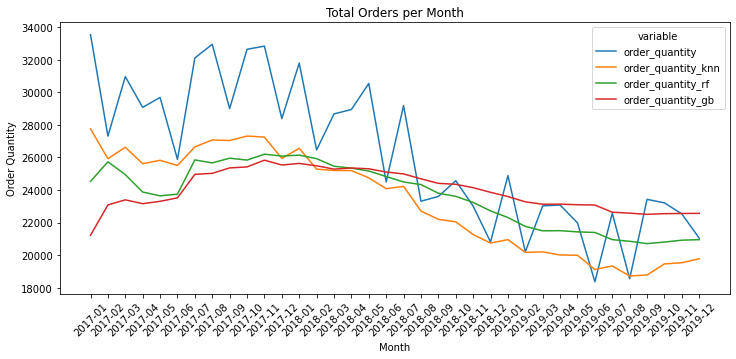

In [35]:
plt.figure(figsize=(12,5))
fig = sns.lineplot(data=monthly_orders_per_model,x='period_str',y='value',hue='variable')
fig.set_title('Total Orders per Month')
fig.set_xlabel('Month')
fig.set_ylabel('Order Quantity')
fig.set_xticklabels(labels=monthly_orders_per_model.period_str,rotation=45);